<a href="https://colab.research.google.com/github/chidellapranav/Digit-Identification/blob/main/Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing the kaggle dataset
from google.colab import files

print("Upload the JSON :")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Upload the JSON :


Saving kaggle.json to kaggle (1).json


In [3]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.10G/2.13G [00:15<00:00, 226MB/s]
100% 2.13G/2.13G [00:15<00:00, 149MB/s]


In [4]:
#Now we've to UNZIP it :
!unzip -q leapgestrecog.zip -d hand_gesture_dataset

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "hand_gesture_dataset"

## CNN : Google LeNet

In [6]:
#Model Defination (Google LeNet ):
import torch.nn as nn

class Inception(nn.Module):
  def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
    super(Inception, self).__init__()
    # 1x1 conv
    self.b1 = nn.Sequential(
        nn.Conv2d(in_planes, n1x1, kernel_size=1),
        nn.BatchNorm2d(n1x1),
        nn.ReLU(True),
    )
    #1x1=>3x3 conv
    self.b2 = nn.Sequential(
        nn.Conv2d(in_planes, n3x3red, kernel_size=1),
        nn.BatchNorm2d(n3x3red),
        nn.ReLU(True),
        nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
        nn.BatchNorm2d(n3x3),
        nn.ReLU(True),
    )
    #1x1=>5x5 conv
    self.b3 = nn.Sequential(
        nn.Conv2d(in_planes, n5x5red, kernel_size=1),
        nn.BatchNorm2d(n5x5red),
        nn.ReLU(True),
        nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
        nn.BatchNorm2d(n5x5),
        nn.ReLU(True),
    )
    #3x3 pool => 1x1
    self.b4 = nn.Sequential(
        nn.MaxPool2d(3, stride=1, padding=1),
        nn.Conv2d(in_planes, pool_planes, kernel_size=1),
        nn.BatchNorm2d(pool_planes),
        nn.ReLU(True),
    )
  def forward(self, x):
    y1 = self.b1(x)
    y2 = self.b2(x)
    y3 = self.b3(x)
    y4 = self.b4(x)
    return torch.cat([y1,y2,y3,y4], 1)



In [7]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## ResNet -18

In [8]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [9]:
#Now transformation on the images to make ot ImageNet standards
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),      # Rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(), # Flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
#Loading of the full dataset :
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

In [11]:
#Splitting of the dataset:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [12]:
val_dataset.dataset.transform = val_transforms
#Validation set to use only validation transforms

In [13]:
#Creation of dataloaders :
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
#Seeing the batch names :
class_names = full_dataset.classes
print(f"Classes found: {class_names}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Classes found: ['leapGestRecog', 'leapgestrecog']
Training samples: 28000, Validation samples: 6000


## Training Loop :

In [15]:
#Training of the CNN model :
import torch.optim as optim
import time

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return history

## Execution Phase for GoogLeNet :

In [16]:
#Executing the training phase :
num_classes = len(class_names)
learning_rate = 0.001
num_epochs = 16

#The above are the hyperparameters of the CNN net

In [17]:
#Instanciate the CNN model by taking CrossEntropy loss and adam optimizer
model = GoogleNet(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
#Training loop for GoogLeNet Architecture  :
#trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

#Execution of ResNet 18 architecture :

In [19]:
# Modify the last fully connected layer to match your dataset
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = classifier_model.fc.in_features
classifier_model.fc = nn.Linear(num_ftrs, num_classes)  # adapt to dataset
classifier_model = classifier_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-3)

In [20]:
# Training of the model :
history = train_model(classifier_model, criterion, optimizer, train_loader, val_loader, epochs=10)

Epoch 1/10 | Train Loss: 0.7069 | Val Loss: 0.6960 | Val Acc: 0.5013
Epoch 2/10 | Train Loss: 0.7014 | Val Loss: 0.6949 | Val Acc: 0.4987
Epoch 3/10 | Train Loss: 0.7006 | Val Loss: 0.6965 | Val Acc: 0.5013
Epoch 4/10 | Train Loss: 0.7003 | Val Loss: 0.7001 | Val Acc: 0.5013
Epoch 5/10 | Train Loss: 0.6997 | Val Loss: 0.6942 | Val Acc: 0.4987
Epoch 6/10 | Train Loss: 0.6975 | Val Loss: 0.7190 | Val Acc: 0.5013
Epoch 7/10 | Train Loss: 0.6958 | Val Loss: 0.7014 | Val Acc: 0.4925
Epoch 8/10 | Train Loss: 0.6953 | Val Loss: 0.6937 | Val Acc: 0.5027
Epoch 9/10 | Train Loss: 0.6950 | Val Loss: 0.7369 | Val Acc: 0.4973
Epoch 10/10 | Train Loss: 0.6946 | Val Loss: 0.6934 | Val Acc: 0.4987


In [21]:
# Evaluation of the model :
classifier_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.5048


In [22]:
torch.save(classifier_model.state_dict(), "hand_gesture_resnet18.pth")

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.7 MB/s eta 0:00:00


In [25]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-10-3 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 50.0MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [26]:
yolo_model.to(device)

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [27]:
classifier_model = models.resnet18(weights="IMAGENET1K_V1")
classifier_model.fc = nn.Linear(classifier_model.fc.in_features, len(class_names))



In [31]:
num_ftrs = classifier_model.fc.in_features
classifier_model.fc = nn.Linear(num_ftrs, 10)   # 10 gesture classes

classifier_model = classifier_model.to(device)

In [34]:
# Load your trained weights (if available)
state_dict = torch.load("hand_gesture_resnet18.pth", map_location=device)

In [ ]:
classifier_model.load_state_dict(torch.load('hand_gesture_googlenet.pth'))


In [36]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k in classifier_model.state_dict() and classifier_model.state_dict()[k].size() == v.size():
        new_state_dict[k] = v

In [37]:
classifier_model.load_state_dict(new_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [38]:
classifier_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
#Now classifier input same as validatio input
classifier_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [49]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
from IPython.display import display, Javascript
from  base64 import b64decode
import numpy as np
from PIL import Image

In [53]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


def capture_and_predict(yolo_model, classifier_model, classifier_transform, class_names, device):
    print("Show a hand gesture to your webcam and click the 'Capture' button.")

    # Step 1: Capture photo
    photo_path = take_photo()
    frame = cv2.imread(photo_path)

    # Step 2: Run YOLO to detect hand/person
    results = yolo_model(frame)
    detections = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2, conf, cls

    if len(detections) == 0:
        print("No hand/person detected.")
        cv2_imshow(frame)
        return

    # Take largest detection
    areas = (detections[:,2]-detections[:,0]) * (detections[:,3]-detections[:,1])
    largest_idx = np.argmax(areas)
    x1, y1, x2, y2 = detections[largest_idx][:4].astype(int)

    # Step 3: Crop hand region
    padding = 20
    hand_crop = frame[max(0,y1-padding):min(frame.shape[0],y2+padding),
                      max(0,x1-padding):min(frame.shape[1],x2+padding)]

    if hand_crop.size == 0:
        print("Empty crop!")
        cv2_imshow(frame)
        return

    # Step 4: Preprocess crop for classifier
    hand_pil = Image.fromarray(cv2.cvtColor(hand_crop, cv2.COLOR_BGR2RGB))
    input_tensor = classifier_transform(hand_pil).unsqueeze(0).to(device)

    # Step 5: Classify gesture
    with torch.no_grad():
        output = classifier_model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_digit = predicted.item()

    # Step 6: Annotate + Show
    cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(frame, f"Predicted: {predicted_digit}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2_imshow(frame)
    print("Predicted Digit:", predicted_digit)

In [42]:
from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")   # small, fast model


# Final Execution :

Show a hand gesture to your webcam and click the 'Capture' button.


<IPython.core.display.Javascript object>


0: 480x640 1 person, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


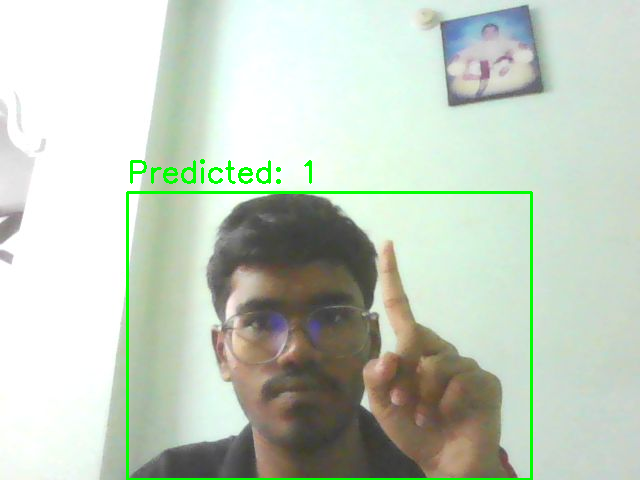

Predicted Digit: 1


In [59]:
capture_and_predict(yolo_model, classifier_model, classifier_transform, class_names, device)